In [1]:
import networkx as nx

In [2]:
#substrate graph 

In [3]:
Gs = nx.Graph()
Gs.add_nodes_from([1,2,3,4,5,6],cpu=20,st=20)
Gs.nodes[3]['st']=17
Gs.nodes[4]['st']=16
Gs.nodes[5]['st']=15
#add edges
Gs.add_edges_from([(1, 2),(1,6),(2,3),(2,5),(3,4),(4,5),(5,6)], weight=20 )

{(1, 2): Text(0.5068334907366123, -0.6133242879583939, '20'),
 (1, 6): Text(-0.004483721326412726, 0.04688718033256917, '20'),
 (2, 3): Text(-0.013621977240105887, -0.02127418642389961, '20'),
 (2, 5): Text(0.04789100211898761, -0.5287123525941848, '20'),
 (3, 4): Text(-0.04340728079257494, 0.48182517226161575, '20'),
 (4, 5): Text(0.018105698566518558, -0.02561299390866939, '20'),
 (5, 6): Text(-0.4634262099440374, 0.1314991156967783, '20')}

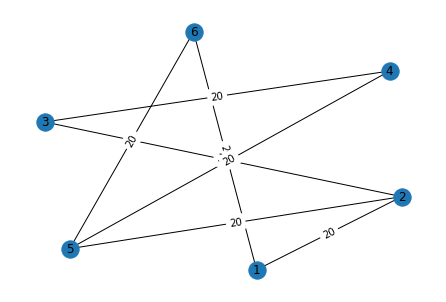

In [4]:
#nx.draw(Gs, with_labels=True, font_weight='bold')

pos = nx.spring_layout(Gs, k=20)  # For better example looking
nx.draw(Gs, pos, with_labels=True)
labels = {e: Gs.edges[e]['weight'] for e in Gs.edges}
nx.draw_networkx_edge_labels(Gs, pos, edge_labels=labels)

In [5]:
#request graph

In [6]:
Gv = nx.Graph()
Gv.add_node(1,cpu=5,st=5)
Gv.add_node(2,cpu=4,st=4)
Gv.add_node(3,cpu=3,st=3)
#add edges
Gv.add_edges_from([(1,2),(2,3),(3,1)],weight=2)

{(1, 2): Text(-0.43301722457733266, -0.2824482920918071, '2'),
 (1, 3): Text(0.3271419014533845, -0.217551707908193, '2'),
 (2, 3): Text(0.10587532312394826, 0.4999999999999999, '2')}

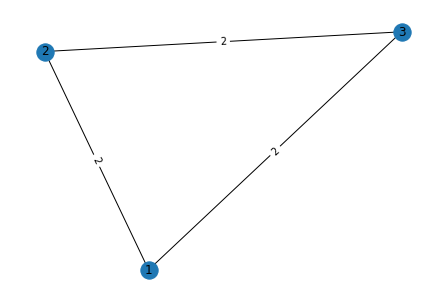

In [7]:
pos = nx.spring_layout(Gv, k=20)  # For better example looking
nx.draw(Gv, pos, with_labels=True)
labels = {e: Gv.edges[e]['weight'] for e in Gv.edges}
nx.draw_networkx_edge_labels(Gv, pos, edge_labels=labels)

In [8]:
GVs = [Gv]

In [9]:
#RCR ratio
def RCR(network):
    temp = []
    for node in network.nodes(data=True):
        rcr = node[1]['cpu']/node[1]['st']
        temp.append((rcr,node[0]))
    return sorted(temp,reverse=True)

In [10]:
#Node Rank Metric
def NRM(network):
    temp = []
    for node in network.nodes(data=True):
        sum_edge = 0
        for edge in network.edges(node[0],data=True):
            sum_edge = sum_edge + edge[2]['weight']
        met = (node[1]['cpu']+node[1]['st'])*(sum_edge)
        temp.append((met,node[0]))
    return sorted(temp,reverse=True)

In [11]:
def node_ranking(fGv):
    rcr_s = RCR(Gs)
    met_v = NRM(fGv)
    mapped = []
    mapping = []
    for node_v in met_v:
        n = fGv.nodes[node_v[1]]
        rcr_v = n['cpu']/n['st']
        diff = 10000
        nv = -1
        ns = -1
        for node in rcr_s:
            if (node[1] not in mapped) and diff>(abs(rcr_v - node[0])) and Gs.nodes(data=True)[node[1]]['cpu']>=fGv.nodes(data=True)[node_v[1]]['cpu'] and Gs.nodes(data=True)[node[1]]['st']>=fGv.nodes(data=True)[node_v[1]]['st']:
                diff = abs(rcr_v - node[0])
                ns = node[1]
                nv = node_v[1]
        if(ns == -1):
            return False, mapping
        
        mapped.append(ns)
        mapping.append({'Nv':nv,'Ns':ns})
    if(len(met_v)==len(mapped)):
        return True, mapping
    return False, mapping

In [12]:
def link_mapping(Vmap,fGv):
    edges=sorted(fGv.edges(data=True), key=lambda t: t[2].get('weight', 1), reverse=True)
    mapping = []
    name_indexer = dict((p['Nv'], i) for i, p in enumerate(Vmap))
    for edge in edges:
        n1 = Vmap[name_indexer.get(edge[0])]['Ns']
        n2 = Vmap[name_indexer.get(edge[1])]['Ns']
        flag = 0
        rmv = []
        for e in list(Gs.edges(data=True)):
            if e[2]['weight']<edge[2]['weight']:
                rmv.append(e)
                Gs.remove_edge(e[0],e[1])
        
        #Find the shortest path
        path = nx.dijkstra_path(Gs,n1,n2,weight = 'weight')
        
        #Add the removed edges
        for ix in rmv:
            Gs.add_edge(ix[0],ix[1],weight=ix[2])
            
        if(len(path)==0):
            return False, []
        
        mapping.append([edge,path])
    
    for p in mapping: 
        for i in range(1,len(p[1])):
            Gs[p[1][i-1]][p[1][i]]['weight'] = Gs[p[1][i-1]][p[1][i]]['weight'] - p[0][2]['weight']
    return True, mapping

In [13]:
def NRM_VNE(Gvs):
    rejected = 0
    accepted = 0
    for NRM_Gv in Gvs:
        flag, Vmap = node_ranking(NRM_Gv)
        if(not flag):
            print('Not mapped')
            rejected = rejected + 1
            continue
        flag, Emap = link_mapping(Vmap,NRM_Gv)
        if(not flag):
            print('Not mapped')
            rejected = rejected + 1
            continue
        accepted = accepted +1
        #updating the Substrate graph CPU and Storage
        for node in Vmap:
            Gs.nodes(data=True)[node['Ns']]['cpu'] = Gs.nodes(data=True)[node['Ns']]['cpu'] - NRM_Gv.nodes(data=True)[node['Nv']]['cpu']
            Gs.nodes(data=True)[node['Ns']]['st'] = Gs.nodes(data=True)[node['Ns']]['st'] - NRM_Gv.nodes(data=True)[node['Nv']]['st']
    print('Acceptance Ratio:' + str(accepted/len(Gvs)))
    print(Vmap)
    print(Emap)

In [14]:
NRM_VNE(GVs)

Acceptance Ratio:1.0
[{'Nv': 1, 'Ns': 6}, {'Nv': 2, 'Ns': 2}, {'Nv': 3, 'Ns': 1}]
[[(1, 2, {'weight': 2}), [6, 1, 2]], [(1, 3, {'weight': 2}), [6, 1]], [(2, 3, {'weight': 2}), [2, 1]]]


{(1, 2): Text(-0.28286337393285604, 0.4164220987696675, '16'),
 (1, 6): Text(0.7089001900008416, 0.49947174180395787, '16'),
 (2, 3): Text(-0.23468206289353144, -0.426179609899892, '20'),
 (2, 5): Text(-0.7453681692753691, 0.3278769386234048, '20'),
 (3, 4): Text(0.03646797927452736, -0.8273486804273628, '20'),
 (4, 5): Text(-0.47421812710731026, -0.07329213190406597, '20'),
 (5, 6): Text(0.24639539465832855, 0.41092658165769513, '20')}

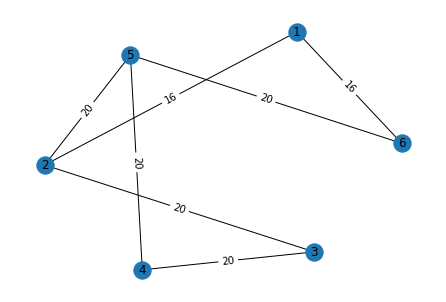

In [15]:
pos = nx.spring_layout(Gs, k=20)  # For better example looking
nx.draw(Gs, pos, with_labels=True)
labels = {e: Gs.edges[e]['weight'] for e in Gs.edges}
nx.draw_networkx_edge_labels(Gs, pos, edge_labels=labels)